# Partie 2 : Classification multiclasse.

Cette partie du projet consiste à comparer les differents modèle de classification pour un scénario à classes multiples et des données relationelles. Nous évaluerons la performance de chaque modèle en utilisant différentes métriques et en nous basant sur des données réelles.

Cette partie contient :
* Une classification des données $X$ (matrice document-termes).
* Une classification sur une combinaison des données $X$ et $W$ (matrice d'adjacence du réseau de citations).



> * $M_p = (D^{-1} \cdot W)^p \cdot X$,  où $D$ est une matrice diagonale, chaque valeur diagonale correspond à la somme des valeurs d’une ligne de $W$.


> * $M$ est une concaténation de $X$ de dimensions $(n, m)$ et $W$ de dimensions $(n, n)$, donc M aura les dimensions $(n, n+m)$.


> * Une classification sur la matrice $U$ des vecteurs singuliers gauche obtenue en appliquant la SVD sur $M_p$,





In [ ]:
from utils import *

In [ ]:
# importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from scipy.io import loadmat
cora = loadmat('data/cora.mat')

In [ ]:
X = cora['fea']
df_X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

W = cora['W']
df_W = pd.DataFrame(W)

Y = cora['gnd'].reshape(-1) - 1
df_Y = pd.DataFrame(Y, columns=['class_label'])

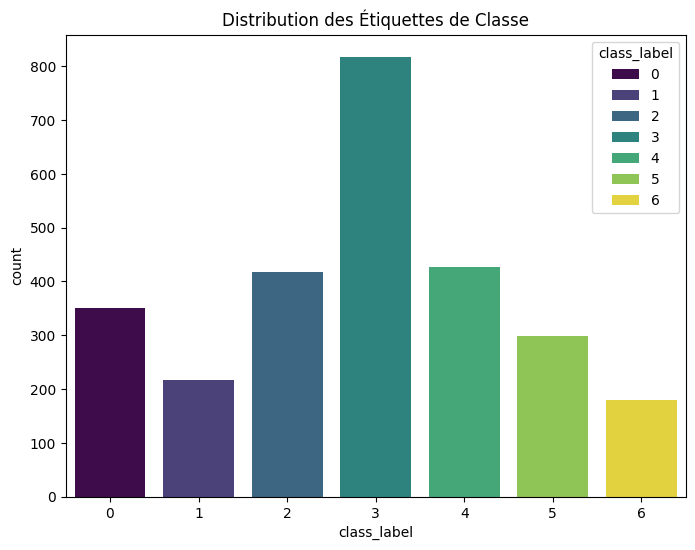

In [ ]:
# Analyse des Étiquettes de Classe (Class Labels)
plt.figure(figsize=(8, 6))
sns.countplot(x='class_label', data=df_Y, palette='viridis', hue='class_label')
plt.title('Distribution des Étiquettes de Classe')
plt.show()

On peut constater que les classes ne sont pas équitablement réparties.

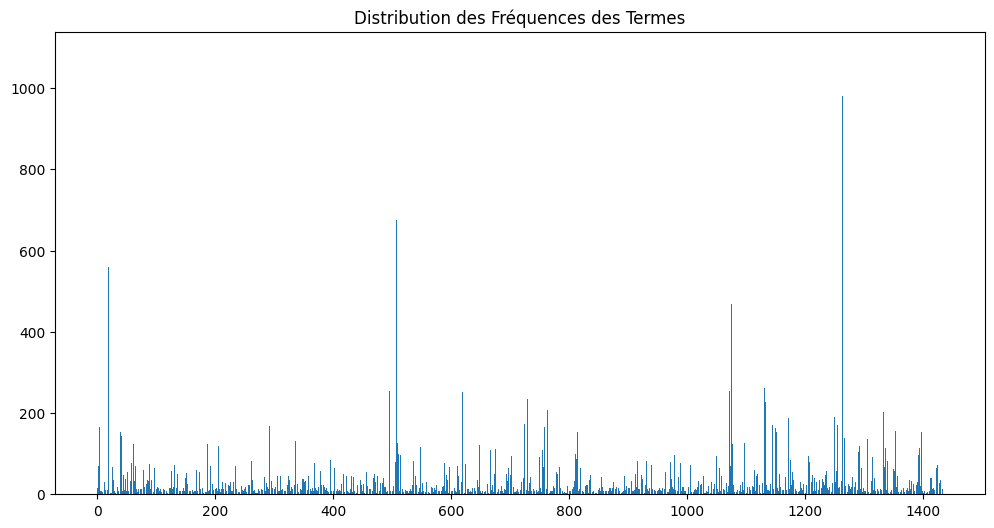

In [ ]:
# Visualisation de la distribution des fréquences des termes
term_frequencies = X.sum(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(len(term_frequencies)), term_frequencies)
#plt.xticks(rotation=90)
plt.title('Distribution des Fréquences des Termes')
plt.show()

On remarque que certains mot ont des occurences très élévées, on suppose que ce sont des stopwords ou des auxiliaires.

## Split dataset into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Classification sur le contenu dans la matrice $X$

In [ ]:
# define imblearn methods to use
imblearn_methods = {
    'Imbalanced': None,
    'Undersampled': RandomUnderSampler,
    'Oversampled': RandomOverSampler,
    'SMOTE': SMOTE,
    'ADASYN': ADASYN,
    'SMOTEENN': SMOTEENN
}

In [ ]:
import time

# compare the algorithms
results_dict_without_scaling = dict()

for key, value in imblearn_methods.items():
    start = time.time()
    print(f'Running {key}')
    results_dict_without_scaling[key] = cross_validation(create_models(balance_method=value), X, Y)
    end = time.time()
    print(f'Finished {key} in {end - start} seconds')
    print("---------------------------------------------")

summary_without_scaling = summarize_results(results_dict_without_scaling)
summary_without_scaling.sort_values(by=['Accuracy', 'F1', 'Precision', 'Recall', 'AUC'], ascending=False, inplace=True, ignore_index=True)
summary_without_scaling.to_csv('summary_without_scaling.csv', index=False)
summary_without_scaling


Running Imbalanced
Finished Imbalanced in 163.32343578338623 seconds
---------------------------------------------
Running Undersampled
Finished Undersampled in 39.92156004905701 seconds
---------------------------------------------
Running Oversampled
Finished Oversampled in 488.6759750843048 seconds
---------------------------------------------
Running SMOTE
Finished SMOTE in 605.3462300300598 seconds
---------------------------------------------
Running ADASYN
Finished ADASYN in 599.7460067272186 seconds
---------------------------------------------
Running SMOTEENN
Finished SMOTEENN in 117.78105878829956 seconds
---------------------------------------------


,Model,Dataset,Accuracy,F1,Precision,Recall,AUC
0,ET,ADASYN,0.779897,0.777097,0.786188,0.779897,0.953629
1,LR,Imbalanced,0.775490,0.773750,0.779626,0.775490,0.951789
2,LR,SMOTE,0.775471,0.772429,0.780236,0.775471,0.950989
3,RF,Oversampled,0.774782,0.774430,0.780367,0.774782,0.948118
4,RF,ADASYN,0.774737,0.773700,0.782508,0.774737,0.945347
...,...,...,...,...,...,...,...
61,SVM,ADASYN,0.302066,0.140154,0.091245,0.302066,0.784954
62,LDA,Undersampled,0.296171,0.300492,0.353231,0.296171,0.656941
63,LDA,SMOTEENN,0.263291,0.266045,0.347100,0.263291,0.603906
64,KNN,SMOTEENN,0.219374,0.121888,0.183592,0.219374,0.585822


Les algorithmes qui ont été plus performants sur les données $X$ non-normalisées sont :
* Extra Trees (ET) avec ADASYN :
Accuracy: 0.7799, F1: 0.7771, AUC: 0.9536.
Performances élevées dans toutes les métriques.
* Logistic Regression (LR) sur le dataset Imbalanced :
Accuracy: 0.7755, F1: 0.7737, AUC: 0.9518.
De bonnes performances globales malgré le déséquilibre des classes.
* Logistic Regression (LR) avec SMOTE :
Accuracy: 0.7755, F1: 0.7724, AUC: 0.9510.
Maintient des performances élevées avec l'utilisation de SMOTE.


Quant à ceux qui n'ont pas de bonnes performances sont:
* K-Nearest Neighbors (KNN) sur le dataset Imbalanced :
Accuracy: 0.4686, F1: 0.4490, AUC: 0.7597.
Les performances sont sensiblement plus basses.
* SVM sur le dataset SMOTE :
Accuracy: 0.3021, F1: 0.1402, AUC: 0.7896.
Performances très faibles, indiquant un besoin potentiel de normalisation.

# Une Combinaison des informations $X$ et $W$

Ici, une méthode de combinaison des information contennues dans X et W est proposée.

$M_p = (D^{-1}W)^pX$, où $D$ est une matrice diagonale, chaque valeur diagonale correspond à la somme des valeurs d’une ligne
de $W$.




In [ ]:
import time


for p in range(1, 3):
    # calculate M^p and U
    print(f'Calculating M^{p}')
    Mp = combine_X_and_W(X, W, p)
    # print(f'Calculating U for M^{p} using SVD')
    # U = combine_X_and_W(X, W, p=p, svd=True) # todo: problem with this, the matrix U returned has shape (2708, 2708) and not (2708, 1433) so check this !!

    # compare the algorithms
    print('Comparing algorithms')
    results_dict = dict()

    for key, value in tqdm(imblearn_methods.items()):
        start = time.time()
        print(f'Running {key}')
        results_dict[key] = cross_validation(create_models(balance_method=value), Mp, Y)

        end = time.time()
        print(f'Finished {key} in {end - start} seconds')
        print("****")

    print("---------------------------------------------")

    summary = summarize_results(results_dict)
    summary.sort_values(by=['Accuracy', 'F1', 'Precision', 'Recall', 'AUC'], ascending=False, inplace=True, ignore_index=True)
    summary.to_csv(f'summary_classification_on_M{p}.csv', index=False)
    summary

Calculating M^1
Comparing algorithms


  0%|          | 0/6 [00:00<?, ?it/s]

Running Imbalanced


 17%|█▋        | 1/6 [02:23<11:57, 143.56s/it]

Finished Imbalanced in 143.56257009506226 seconds
****
Running Undersampled


 33%|███▎      | 2/6 [03:12<05:52, 88.13s/it] 

Finished Undersampled in 49.324383020401 seconds
****
Running Oversampled


 50%|█████     | 3/6 [09:32<11:03, 221.08s/it]

Finished Oversampled in 379.2923049926758 seconds
****
Running SMOTE


 67%|██████▋   | 4/6 [18:08<11:15, 337.59s/it]

Finished SMOTE in 516.1829478740692 seconds
****
Running ADASYN


 83%|████████▎ | 5/6 [27:28<06:57, 417.77s/it]

Finished ADASYN in 559.9485161304474 seconds
****
Running SMOTEENN


100%|██████████| 6/6 [37:35<00:00, 375.87s/it]

Finished SMOTEENN in 606.8818011283875 seconds
****
---------------------------------------------
Calculating M^2


Comparing algorithms


  0%|          | 0/6 [00:00<?, ?it/s]

Running Imbalanced


 17%|█▋        | 1/6 [05:00<25:03, 300.76s/it]

Finished Imbalanced in 300.75578594207764 seconds
****
Running Undersampled


 33%|███▎      | 2/6 [07:00<12:58, 194.51s/it]

Finished Undersampled in 120.12898898124695 seconds
****
Running Oversampled


 50%|█████     | 3/6 [15:57<17:32, 350.80s/it]

Finished Oversampled in 536.7790179252625 seconds
****
Running SMOTE


 67%|██████▋   | 4/6 [30:39<18:40, 560.36s/it]

Finished SMOTE in 881.6078541278839 seconds
****
Running ADASYN


 83%|████████▎ | 5/6 [44:13<10:51, 651.79s/it]

Finished ADASYN in 813.9043879508972 seconds
****
Running SMOTEENN


100%|██████████| 6/6 [54:14<00:00, 542.37s/it]

Finished SMOTEENN in 601.015499830246 seconds
****
---------------------------------------------


On note que les performances des modèles s'améliorent en augmentant P. Cependant, au-delà de P=3, nous observons une diminution des performances.

## Concatenation de $X$ et $W$

Ici, une autre façon de combiner $X$ et $W$ est proposée, celle-ci consiste à concaténer les deux matrices $X$ et $W$ de façon à ajouter les colonnes de $W$ comme des features de la matrice $X$.

In [ ]:
def concatenate_X_and_W(X, W):
    # X est une matrice de taille (n, d)
    # W est une matrice de taille (n, n)
    # Concaténation des matrices X et W (colonnes) pour obtenir une matrice de taille (n, d + n)
    M = np.concatenate((X, W), axis=1)
    assert M.shape == (X.shape[0], X.shape[1] + W.shape[1])
    return M

In [ ]:
M = concatenate_X_and_W(X, W)

# compare the algorithms
print('Comparing algorithms')
results_dict = dict()

for key, value in tqdm(imblearn_methods.items()):
    start = time.time()
    print(f'Running {key}')
    results_dict[key] = cross_validation(create_models(balance_method=value), M, Y)

    end = time.time()
    print(f'Finished {key} in {end - start} seconds')
    print("****")

print("---------------------------------------------")

summary = summarize_results(results_dict)
summary.sort_values(by=['Accuracy', 'F1', 'Precision', 'Recall', 'AUC'], ascending=False, inplace=True, ignore_index=True)
summary.to_csv(f'summary_classification_on_concatenated_X_and_W.csv', index=False)
summary

Comparing algorithms


  0%|          | 0/6 [00:00<?, ?it/s]

Running Imbalanced


 17%|█▋        | 1/6 [07:51<39:17, 471.55s/it]

Finished Imbalanced in 471.55163502693176 seconds
****
Running Undersampled


 33%|███▎      | 2/6 [10:02<18:03, 270.98s/it]

Finished Undersampled in 130.57241487503052 seconds
****
Running Oversampled


 50%|█████     | 3/6 [27:09<30:48, 616.14s/it]

Finished Oversampled in 1026.8773691654205 seconds
****
Running SMOTE


 67%|██████▋   | 4/6 [50:15<30:40, 920.26s/it]

Finished SMOTE in 1386.4715280532837 seconds
****
Running ADASYN


 83%|████████▎ | 5/6 [1:13:57<18:21, 1101.09s/it]

Finished ADASYN in 1421.729339838028 seconds
****
Running SMOTEENN


100%|██████████| 6/6 [1:19:47<00:00, 797.97s/it] 

Finished SMOTEENN in 350.5925769805908 seconds
****
---------------------------------------------


,Model,Dataset,Accuracy,F1,Precision,Recall,AUC
0,ET,ADASYN,0.846764,0.846177,0.851559,0.846764,0.973083
1,ET,SMOTE,0.841563,0.839875,0.845064,0.841563,0.972115
2,LR,Oversampled,0.827187,0.827031,0.832056,0.827187,0.969299
3,LR,SMOTE,0.825327,0.824286,0.830896,0.825327,0.969542
4,LR,ADASYN,0.823857,0.822605,0.829320,0.823857,0.968813
...,...,...,...,...,...,...,...
61,LDA,SMOTE,0.299496,0.288045,0.291180,0.299496,0.579249
62,LDA,ADASYN,0.290991,0.274705,0.276324,0.290991,0.572292
63,LDA,SMOTEENN,0.259220,0.276828,0.428323,0.259220,0.618897
64,KNN,SMOTEENN,0.198643,0.103159,0.339484,0.198643,0.602562


* Les méthodes basées sur des ensembles comme Extra Trees (ET), Random Forest (RF), et Gradient Boosting (GBM) semblent généralement bien performer.
* L'utilisation de techniques d'échantillonnage comme ADASYN ou SMOTE peut améliorer les performances.
* Les résultats de la régression logistique montrent que l'oversampling et les techniques SMOTE améliorent les performances.
* KNN semble avoir des performances plus faibles dans l'ensemble, et l'échantillonnage peut ne pas avoir un impact significatif.
* NB, LDA et CART (Classification and Regression Trees) présentent des performances variables en fonction de la méthode d'échantillonnage.

## SVD

In [ ]:
def svd_test(Mp):
    # Calcul de la SVD de M
    U, S, _ = np.linalg.svd(Mp) # U, S, V = np.linalg.svd(Mp)
    return np.dot(U, np.diag(S))

In [ ]:
svdM1 = combine_X_and_W(X, W, 1, svd=True)

# compare the algorithms
print('Comparing algorithms')
results_dict = dict()

for key, value in tqdm(imblearn_methods.items()):
    start = time.time()
    print(f'Running {key}')
    results_dict[key] = cross_validation(create_models(balance_method=value), svdM1, Y)

    end = time.time()
    print(f'Finished {key} in {end - start} seconds')
    print("****")

print("---------------------------------------------")

summary = summarize_results(results_dict)
summary.sort_values(by=['Accuracy', 'F1', 'Precision', 'Recall', 'AUC'], ascending=False, inplace=True, ignore_index=True)
summary.to_csv(f'summary_classification_on_svdM1.csv', index=False)
summary

Comparing algorithms


  0%|          | 0/6 [00:00<?, ?it/s]

Running Imbalanced


 17%|█▋        | 1/6 [17:49<1:29:06, 1069.23s/it]

Finished Imbalanced in 1069.223551273346 seconds
****
Running Undersampled


 33%|███▎      | 2/6 [24:25<44:53, 673.29s/it]   

Finished Undersampled in 396.12286496162415 seconds
****
Running Oversampled


 50%|█████     | 3/6 [50:54<54:34, 1091.36s/it]

Finished Oversampled in 1588.8518590927124 seconds
****
Running SMOTE


 67%|██████▋   | 4/6 [1:25:53<49:38, 1489.32s/it]

Finished SMOTE in 2099.4023542404175 seconds
****
Running ADASYN


 83%|████████▎ | 5/6 [2:00:55<28:30, 1710.08s/it]

Finished ADASYN in 2101.4887108802795 seconds
****
Running SMOTEENN


100%|██████████| 6/6 [2:21:57<00:00, 1419.65s/it]

Finished SMOTEENN in 1262.8085911273956 seconds
****
---------------------------------------------


,Model,Dataset,Accuracy,F1,Precision,Recall,AUC
0,XGB,Oversampled,0.806489,0.805875,0.809589,0.806489,0.960007
1,XGB,Imbalanced,0.805773,0.805047,0.809613,0.805773,0.958403
2,XGB,SMOTE,0.800957,0.800038,0.804553,0.800957,0.956241
3,XGB,ADASYN,0.797622,0.796244,0.801386,0.797622,0.957506
4,GBM,Imbalanced,0.783973,0.783375,0.792417,0.783973,0.952400
...,...,...,...,...,...,...,...
61,LR,SMOTEENN,0.307987,0.243195,0.378761,0.307987,0.792895
62,KNN,Undersampled,0.291374,0.196093,0.421900,0.291374,0.614273
63,KNN,SMOTEENN,0.285847,0.247139,0.607129,0.285847,0.679541
64,SVM,SMOTEENN,0.254428,0.204105,0.677288,0.254428,0.791256


In [ ]:

svdM2 = combine_X_and_W(X, W, 2, svd=True)

# compare the algorithms
print('Comparing algorithms')
results_dict = dict()

for key, value in tqdm(imblearn_methods.items()):
    start = time.time()
    print(f'Running {key}')
    results_dict[key] = cross_validation(create_models(balance_method=value), svdM2, Y)

    end = time.time()
    print(f'Finished {key} in {end - start} seconds')
    print("****")

print("---------------------------------------------")

summary = summarize_results(results_dict)
summary.sort_values(by=['Accuracy', 'F1', 'Precision', 'Recall', 'AUC'], ascending=False, inplace=True, ignore_index=True)
summary.to_csv(f'summary_classification_on_svdM2.csv', index=False)
summary

Comparing algorithms


  0%|          | 0/6 [00:00<?, ?it/s]

Running Imbalanced


 17%|█▋        | 1/6 [14:44<1:13:40, 884.14s/it]

Finished Imbalanced in 884.1367433071136 seconds
****
Running Undersampled


 33%|███▎      | 2/6 [20:51<38:41, 580.25s/it]  

Finished Undersampled in 367.5319678783417 seconds
****
Running Oversampled


 50%|█████     | 3/6 [45:28<49:29, 989.83s/it]

Finished Oversampled in 1477.2263209819794 seconds
****
Running SMOTE


 67%|██████▋   | 4/6 [1:18:36<46:07, 1383.78s/it]

Finished SMOTE in 1987.6927349567413 seconds
****
Running ADASYN


 83%|████████▎ | 5/6 [1:51:16<26:31, 1591.40s/it]

Finished ADASYN in 1959.5236620903015 seconds
****
Running SMOTEENN


100%|██████████| 6/6 [2:12:34<00:00, 1325.68s/it]

Finished SMOTEENN in 1277.9750969409943 seconds
****
---------------------------------------------


,Model,Dataset,Accuracy,F1,Precision,Recall,AUC
0,XGB,Oversampled,0.807962,0.807714,0.811931,0.807962,0.959648
1,XGB,Imbalanced,0.807603,0.807203,0.811209,0.807603,0.957883
2,XGB,ADASYN,0.803547,0.803480,0.807448,0.803547,0.957431
3,XGB,SMOTE,0.800965,0.801060,0.806105,0.800965,0.957813
4,GBM,Imbalanced,0.782881,0.782442,0.790570,0.782881,0.952942
...,...,...,...,...,...,...,...
61,LDA,SMOTEENN,0.297704,0.287643,0.382683,0.297704,0.613961
62,KNN,Undersampled,0.277730,0.182482,0.495336,0.277730,0.616818
63,KNN,SMOTEENN,0.272542,0.231973,0.603814,0.272542,0.675430
64,SVM,SMOTEENN,0.254786,0.205419,0.652043,0.254786,0.794645


In [ ]:
svdM3 = combine_X_and_W(X, W, 3, svd=True)

# compare the algorithms
print('Comparing algorithms')
results_dict = dict()

for key, value in tqdm(imblearn_methods.items()):
    start = time.time()
    print(f'Running {key}')
    results_dict[key] = cross_validation(create_models(balance_method=value), svdM3, Y)

    end = time.time()
    print(f'Finished {key} in {end - start} seconds')
    print("****")

print("---------------------------------------------")

summary = summarize_results(results_dict)
summary.sort_values(by=['Accuracy', 'F1', 'Precision', 'Recall', 'AUC'], ascending=False, inplace=True, ignore_index=True)
summary.to_csv(f'summary_classification_on_svdM3.csv', index=False)
summary

Comparing algorithms


  0%|          | 0/6 [00:00<?, ?it/s]

Running Imbalanced


 17%|█▋        | 1/6 [14:14<1:11:10, 854.02s/it]

Finished Imbalanced in 854.0220770835876 seconds
****
Running Undersampled


 33%|███▎      | 2/6 [20:14<37:34, 563.57s/it]  

Finished Undersampled in 360.2516417503357 seconds
****
Running Oversampled


 50%|█████     | 3/6 [44:10<48:05, 961.92s/it]

Finished Oversampled in 1435.9650509357452 seconds
****
Running SMOTE


 67%|██████▋   | 4/6 [1:16:36<45:01, 1350.62s/it]

Finished SMOTE in 1946.486349105835 seconds
****
Running ADASYN


 83%|████████▎ | 5/6 [1:49:38<26:18, 1578.06s/it]

Finished ADASYN in 1981.3366782665253 seconds
****
Running SMOTEENN


100%|██████████| 6/6 [2:11:20<00:00, 1313.47s/it]

Finished SMOTEENN in 1302.7668297290802 seconds
****
---------------------------------------------


,Model,Dataset,Accuracy,F1,Precision,Recall,AUC
0,XGB,Imbalanced,0.812405,0.811156,0.816743,0.812405,0.959222
1,XGB,Oversampled,0.805747,0.805458,0.809256,0.805747,0.959241
2,XGB,SMOTE,0.801348,0.801272,0.805190,0.801348,0.957850
3,XGB,ADASYN,0.801317,0.800921,0.804587,0.801317,0.956179
4,GBM,Imbalanced,0.789168,0.788732,0.796649,0.789168,0.953880
...,...,...,...,...,...,...,...
61,LR,SMOTEENN,0.312390,0.246258,0.383943,0.312390,0.787313
62,KNN,SMOTEENN,0.307582,0.264934,0.640109,0.307582,0.683540
63,LDA,SMOTEENN,0.305002,0.287315,0.389202,0.305002,0.619104
64,SVM,SMOTEENN,0.260333,0.214718,0.705722,0.260333,0.786226


*On* remarque que les performances en appliquant SVD sont plus faibles qu'avec la méthode de concaténation et ce sur les différentes matrices $M_p$.